In [684]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [685]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [686]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [687]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Посмотрим на распределение целевого признака

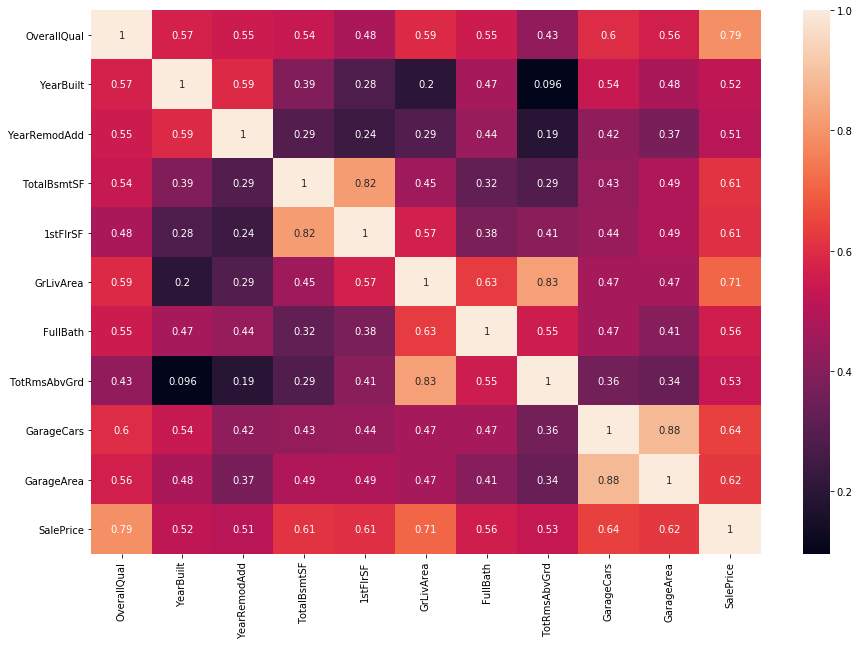

In [688]:
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(15,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True)

In [689]:
train.corr()["SalePrice"].sort_values(ascending = False)[:10]

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

Удаление выбросов в данных

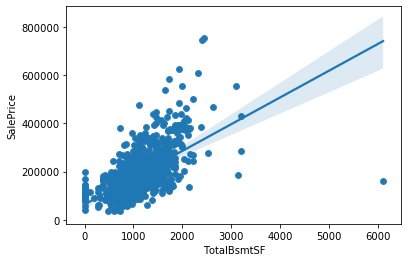

In [690]:
sns.scatterplot(x=train.TotalBsmtSF, y=train.SalePrice)
sns.regplot(x=train.TotalBsmtSF, y=train.SalePrice)

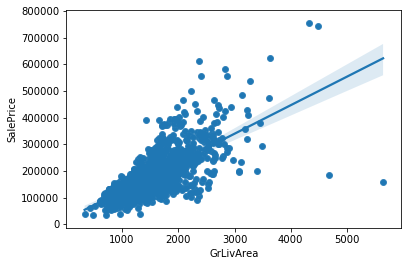

In [691]:
sns.scatterplot(x=train.GrLivArea, y=train.SalePrice)
sns.regplot(x=train.GrLivArea, y=train.SalePrice)

In [692]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['TotalBsmtSF']>4000) & (train['SalePrice']<300000)].index)

In [693]:
train_shape = train.shape[0]
test_shape = test.shape[0]

In [694]:
data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                  test.loc[:,'MSSubClass':'SaleCondition']))

Заполнение пропущенных данных в соответствии с описанием признаков

In [695]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(15)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806


In [696]:
data["PoolQC"] = data["PoolQC"].fillna("None")
data["MiscFeature"] = data["MiscFeature"].fillna("None")
data["Alley"] = data["Alley"].fillna("None")
data["Fence"] = data["Fence"].fillna("None")
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")

In [697]:
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [698]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')

In [699]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)

In [700]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)

In [701]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')

In [702]:
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

In [703]:
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])

In [704]:
data = data.drop(['Utilities'], axis=1)

In [705]:
data["Functional"] = data["Functional"].fillna("Typ")

In [706]:
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

In [707]:
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])

In [708]:
for col in ('Exterior1st', 'Exterior2nd'):
    data[col] = data[col].fillna(data[col].mode()[0])

In [709]:
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])

In [710]:
data['MSSubClass'] = data['MSSubClass'].fillna("None")

In [711]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head()

,Missing Ratio


Конвертирование количественных признаков в категориальные

In [712]:
for col in ('MSSubClass', 'OverallQual', 'OverallCond', 'YrSold', 'MoSold'):
    data[col] = data[col].astype(str)

Преобразование асимметрических признаков

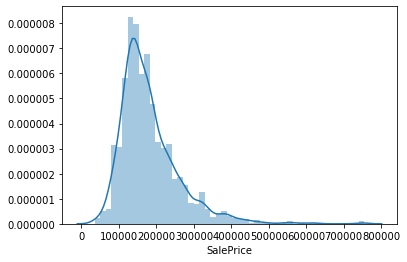

In [713]:
sns.distplot(train['SalePrice'])

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000], dtype=int64)),
 (74213.25959976624, 180932.91906721535, 0.9320154492892367))

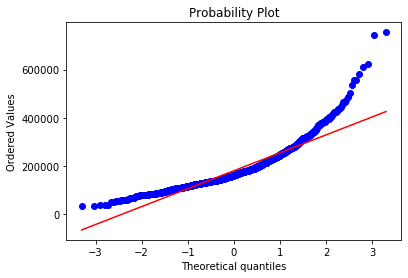

In [714]:
stats.probplot(train['SalePrice'], plot=plt)

Необходимо преобразовать переменную и сделать ее более нормально распределенной.

In [715]:
train["SalePrice"] = np.log1p(train["SalePrice"])

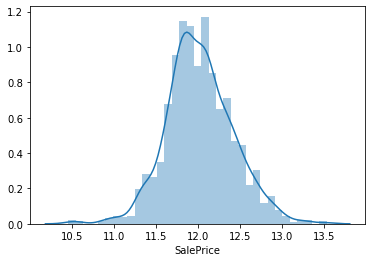

In [716]:
sns.distplot(train['SalePrice'])

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.3985294832980731, 12.024015155682548, 0.9953918721417083))

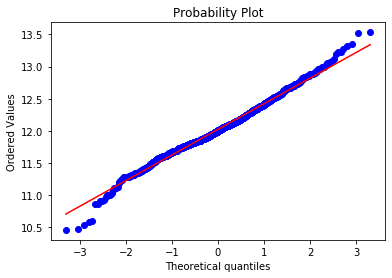

In [717]:
stats.probplot(train['SalePrice'], plot=plt)

In [718]:
numeric_feats = data.dtypes[data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: stats.skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
data[skewed_feats] = np.log1p(data[skewed_feats])

Создание фиктивных переменных

In [719]:
data = pd.get_dummies(data)

Моделирование

In [720]:
y = train.SalePrice

In [721]:
from sklearn.model_selection import cross_val_score, train_test_split

In [722]:
X_train,X_test,y_train,y_test = train_test_split(data[:train_shape],y,test_size = 0.3, random_state = 0)

In [723]:
from sklearn.model_selection import KFold

n_folds = 5
kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(data[:train_shape].values)

def rmse_CV_train(model):
    rmse = np.sqrt(-cross_val_score(model,X_train,y_train,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)
def rmse_CV_test(model):
    rmse = np.sqrt(-cross_val_score(model,X_test,y_test,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)

In [724]:
from sklearn.linear_model import LinearRegression

In [725]:
lr = LinearRegression()
lr.fit(X_train,y_train)
test_pre = lr.predict(X_test)
train_pre = lr.predict(X_train)
print('rmse on train',rmse_CV_train(lr).mean())
print('rmse on test',rmse_CV_test(lr).mean())

rmse on train 0.15041795216256704
rmse on test 0.2389944058001424


График остатков

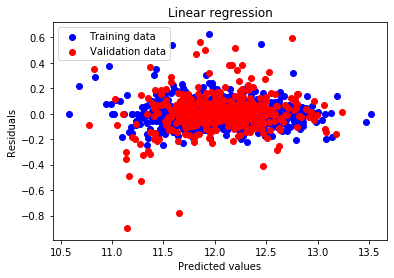

In [726]:
plt.scatter(train_pre, train_pre - y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre,test_pre - y_test, c = "red",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()

График сравнения предсказанных и реалных значений

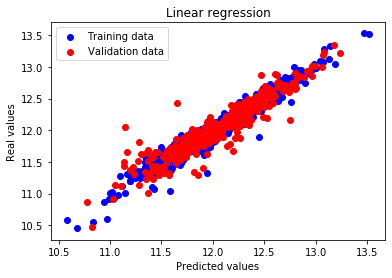

In [727]:
plt.scatter(train_pre, y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre, y_test, c = "red",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.show()

Применим регуляризацию

In [728]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60], cv = kf)
ridge.fit(X_train,y_train)
alpha = ridge.alpha_
print('best alpha',alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], cv = kf)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_CV_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_CV_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

best alpha 6.0
Try again for more precision with alphas centered around 6.0
Best alpha : 6.8999999999999995
Ridge RMSE on Training set : 0.12087028072001549
Ridge RMSE on Test set : 0.13387524113453875


In [729]:
lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0001, 0.00001], cv = kf, max_iter = 100000)
lasso.fit(X_train,y_train)
alpha = lasso.alpha_
print('best alpha',alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], cv = kf, max_iter = 100000)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_CV_train(lasso).mean())
print("Ridge RMSE on Test set :", rmse_CV_test(lasso).mean())
y_train_ls = lasso.predict(X_train)
y_test_ls = lasso.predict(X_test)

best alpha 0.001
Try again for more precision with alphas centered around 0.001
Best alpha : 0.0006
Ridge RMSE on Training set : 0.12071191852868564
Ridge RMSE on Test set : 0.12995181384089394


In [730]:
coef = pd.Series(lasso.coef_, index = X_train.columns)

In [731]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

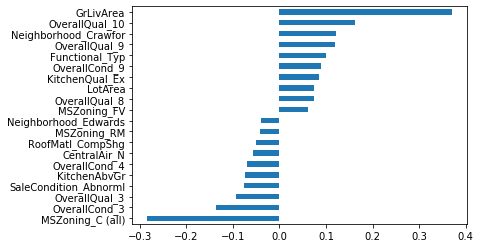

In [732]:
imp_coef.plot(kind = "barh")

In [737]:
submission = pd.read_csv("sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(lasso.predict(data[train_shape:])))
submission.to_csv("submission.csv", index=False)

Predict submission
